<a href="https://colab.research.google.com/github/Alejandro-Javierre/Simple-binary-and-multi-class-perceptron/blob/main/Stellar_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Input**
*Data consists of a .CSV containing 100,000 rows*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection as sklearn_model
import sklearn
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#Reading csv
data = pd.read_csv("/content/drive/MyDrive/Stellar_Classification/star_classification.csv")

##**Data Cleaning**

*Run an initial analysis of histograms for each column in the dataset to look for outliers and skewed data*

100%|██████████| 3/3 [04:26<00:00, 88.82s/it]


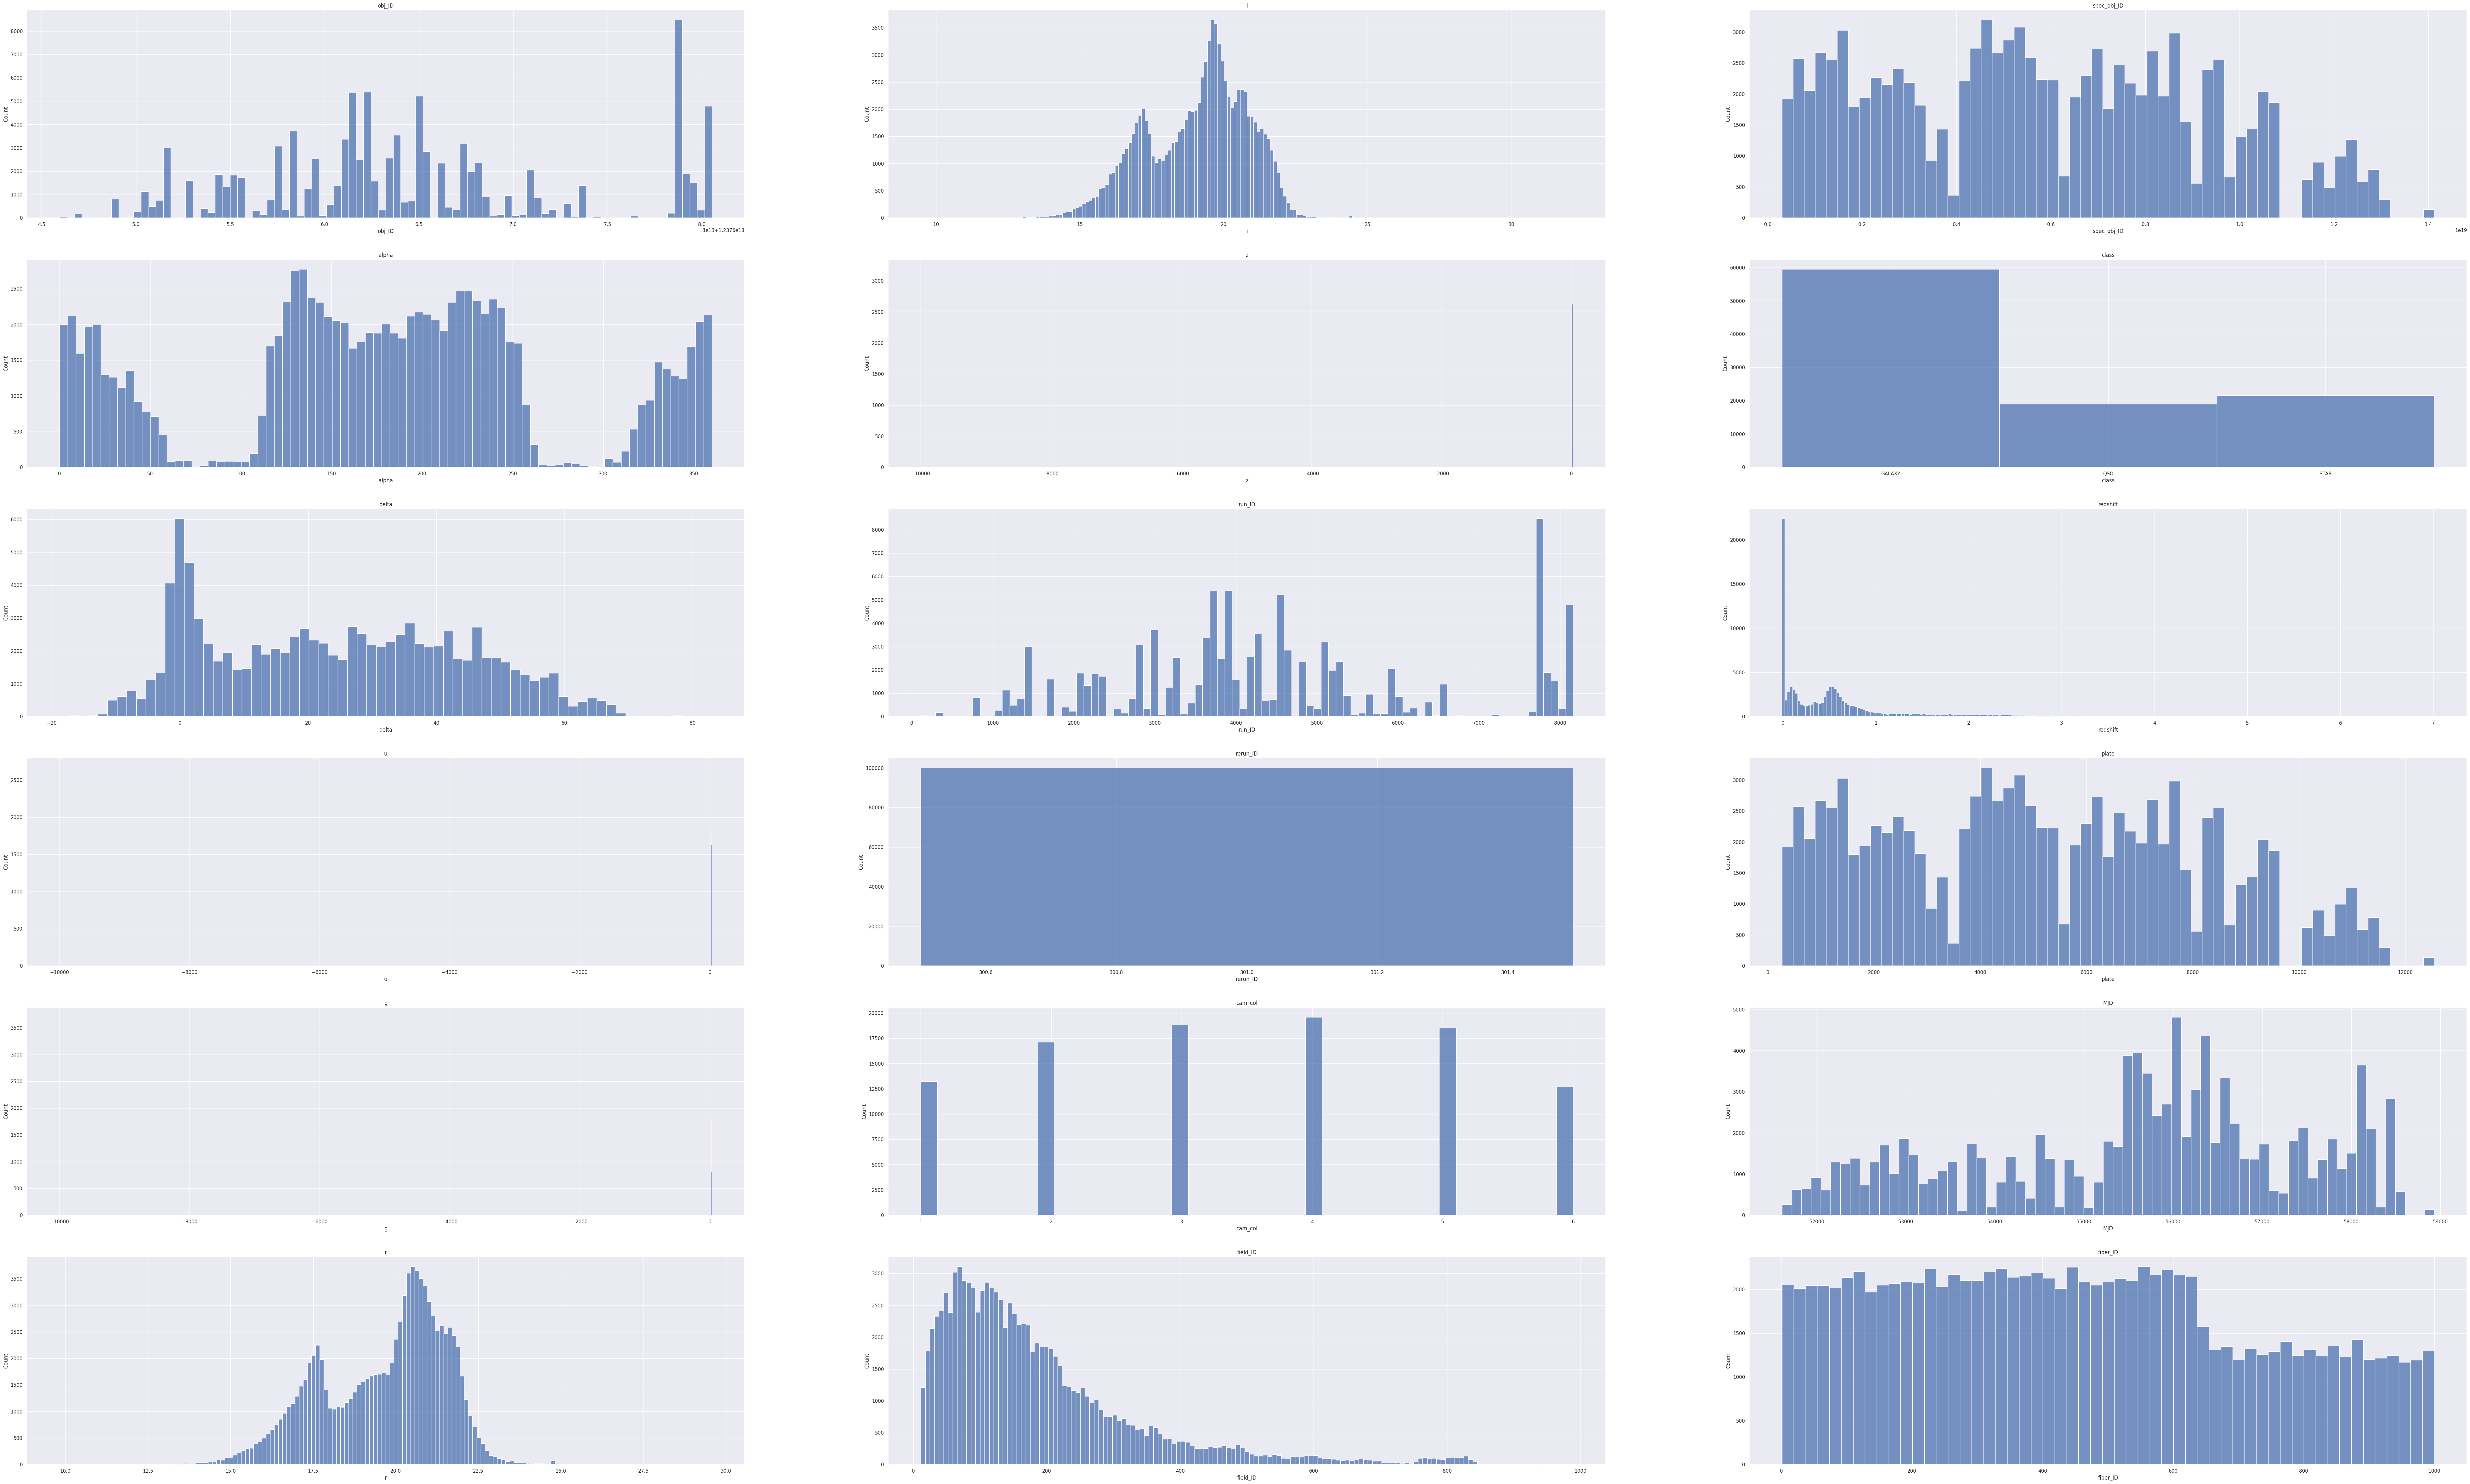

In [2]:
#Checking out the Histograms
sns.set()
fig, axes = plt.subplots(nrows=6,ncols=3,figsize=(100,60))
column_count = 0
for y in tqdm(range(0, 3)):
    for x in range(0, 6):
        sns.histplot(data=data.iloc[:, column_count], 
                     ax=axes[x, y])
        axes[x, y].set_title(data.columns[column_count])
        column_count += 1
        if column_count == 18:
            break

As can be seen from the initial histograms, some columns appear to have significant positive or negative skews, which may affect a deep learning model's ability to fit to the data. Furthermore, the is an imbalance in the classes the model will be differentiating, with around 60,000 galaxies and only around 20,000 QSOs and Stars.

Moreover, a number of columns appear to indicate the presence of extreme outlier values. Most notably, the U and G columns appear to have outliers when looking at the way the histogram has been constructed. It will be important to clean these columns first.

Minimum for U column: -9999.0
Mean for U Column: 21.98046826899982
Post-Cleaning Minumum for U column: 10.99623


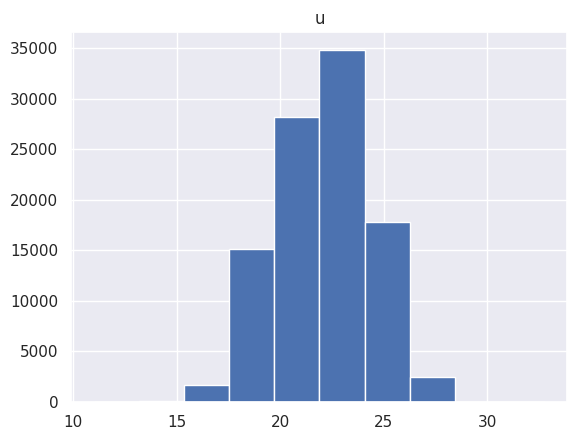

Minumum for G Column: 10.4982
Mean for G Column: 20.631583277432778
Post-Cleaning Minimum for G Column: 10.4982


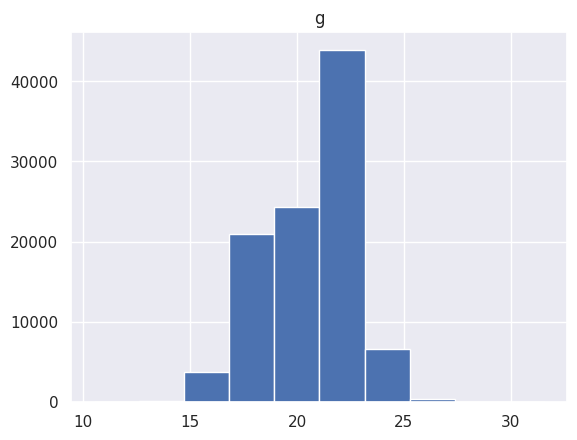

New Row counts:  99999


In [3]:
print("Minimum for U column: " + str(min(data['u'])))
print("Mean for U Column: " + str(sum(data['u'])/len(data['u'])))

#Removing values below -1000
data = data[data['u'] > -1000]
print("Post-Cleaning Minumum for U column: " + str(min(data['u'])))

#fixed runthrough
plt.hist(data['u'])
plt.title('u')
plt.show()

#does g have a cleaning Issue
print("Minumum for G Column: " + str(min(data['g'])))
print("Mean for G Column: " + str(sum(data['g'])/len(data['g'])))

print("Post-Cleaning Minimum for G Column: " + str(min(data['g'])))

#fixed runthrough
plt.hist(data['g'])
plt.title('g')
plt.show()

print("New Row counts: ", str(len(data)))

Both columns don't appear to have many values which are below -1000, so I decided for simplicity to remove extreme outlying values for the U, G and Z column.

It also appears that removing extreme outliers for the U column has also removed outliers for the G column as well, and the post-cleaning counts also appear to show little loss of cases from thids cleaning.

Looking at the histograms for G and U, they both also appear to show a roughly normal distribution, with a slight positive skew - however the effect of this on the model may be negligible.

9.612333
18.76898801211009


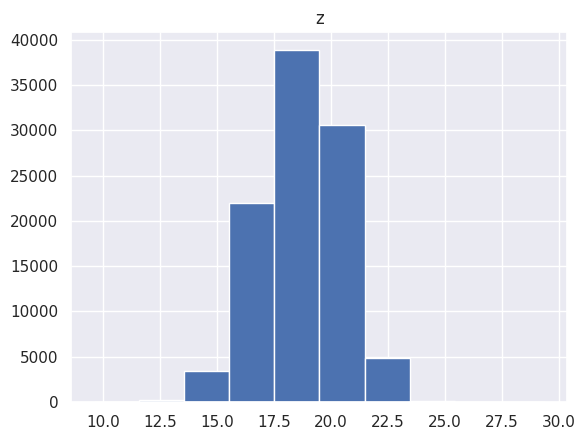

In [4]:
#does z have a cleaning Issue
print(min(data['z']))
print(sum(data['z'])/len(data['z']))

#fixed runthrough
plt.hist(data['z'])
plt.title('z')
plt.show()

As can further been seen from a histogram of the Z column, the previous data cleaning has also removed outliers here as well. This could possibly be due to an error with the equipment used to record these values.

##**Preparing the data for the deep learning model**

*This will involve converting the classes into numerical form, removing the unnecessary ID columns and creating the train/test split.

In [5]:

#Filtering by the columns that will be used in the model

data_cleaned = data.loc[:, ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class']]

#Turning Class into numbers

data_cleaned['class'] = np.where(data_cleaned['class'] == "GALAXY", 0, data_cleaned['class'])
data_cleaned['class'] = np.where(data_cleaned['class'] == "STAR", 1, data_cleaned['class'])
data_cleaned['class'] = np.where(data_cleaned['class'] == "QSO", 2, data_cleaned['class'])


data_cleaned = data_cleaned.iloc[:, 0:]
print(data_cleaned.head(5))

        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   redshift class  
0  0.634794     0  
1  0.779136     0  
2  0.644195     0  
3  0.932346     0  
4  0.116123     0  


For this classification task, Galaxies will be classified as 0, Stars will be 1 and finally QSOs will be 2, this is required to line up the classifications with the Pytorch model.

In [6]:
#Defining train and test

#Creating the unlabeled values to feed into the model
data_clean_x = data_cleaned.iloc[:, :-1]
#Creating the labels for training and validation
data_clean_y = data_cleaned.iloc[:, -1]
data_columns = data_cleaned.columns.values

#Normalizing values before being used in the model - offsets any skewed data and differences in column scales
scaler = sklearn.preprocessing.StandardScaler().fit(data_clean_x)
data_clean_x_scaled = scaler.transform(data_clean_x)

#Converting the normalized data back into a pandas dataframe for easy transferral
data_clean = pd.DataFrame(np.c_[data_clean_x_scaled, data_clean_y], columns = data_columns)

#Splitting the data witrh a 9:1 train/test ratio
data_train, data_test = sklearn_model.train_test_split(data_clean, test_size=0.1)

print(data_train.head(5))

          alpha     delta         u         g         r         i         z  \
52994  0.845134     0.131  1.142561  0.767707  1.018201  0.901003  1.000594   
32728  0.611588  0.877586  0.156602  0.136503 -0.247109 -0.308907 -0.347428   
19563 -0.480702  1.416374 -0.229949 -0.231113  0.123064  0.411558   0.55873   
71251 -0.512589  0.007711 -1.753336 -1.996596 -2.023151 -1.970346 -1.882672   
46139 -0.194433 -0.119119  1.342339  0.899072  0.459799  0.246349  0.174681   

       redshift class  
52994 -0.789114     1  
32728 -0.258977     0  
19563 -0.789341     1  
71251 -0.789552     1  
46139  0.026096     0  


I normalized all of the columns I will be using for two reasons, fist, to offset the impact of any skewed columns that I hadn't noticed in my previous step, and also to make sure that every column's scale was weighted differently, which is important when including categories of different types in deep learning.

My decision to go with a 9:1 train/test ratio instead of the commonly used 8:2 ration was due to the number of cases in the dataset. I believe that 10,000 test cases is sufficient to guage the accuracy of the model, but there is still a potential for overfitting that might not be captured by the validation process.

In [7]:
#Shuffle the training set
data_train = sklearn.utils.shuffle(data_train)

#re-define the data and labels
data_train_x_frame = data_train.iloc[:, :-1]
data_train_y_frame = data_train.iloc[:, 8]

#Ensuring that the labels are in a data type which can be ready by Pytorch
data_train_y_frame = data_train_y_frame.astype('int64')

#Turning the training data and labels into tensors to be read by Pytorch
data_train_x = torch.from_numpy(data_train_x_frame.to_numpy(dtype="float32"))
data_train_y = torch.from_numpy(data_train_y_frame.to_numpy())

data_test_x = torch.tensor(data_test.iloc[:, :-1].astype('float32').values)
data_test_y = data_test.iloc[:, 8].astype('float32')

Before I define the model, I need to convert the training data into tensors to be read by pytorch.

##**Defining my Model**

*defining the hyperparameters and architecture*

In [8]:
#Defining the hyperparameters

n_input = len(data_train_x_frame.columns) #Defining the number of input columns
n_hidden = 6  #Defining the number of neurons in each hidden layer
n_out = 3 #The number of classes to be distinguished (the number of output neurons)
train_batch_size = 100  #The number of cases passed through each batch in the data loader
learning_rate = 0.001 #The learning rate of the model (Lower means less training impact, higher means more chance of overstepping on loss)

classes = ['Galaxy', 'Star', 'QSO']

I decided to make a relatively simple deep learning model, which consisted of a number of hidden layers, each with 6 neurons before having a final output layer of one neuron for each class. I will then use a softmax function to determine the most likely class.

In [9]:
#This class takes in data_x, a tensor, and data_y, a numpy series with classes
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
    def __len__(self):
        return len(self.data_y)
    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]
        
train_dataloader = DataLoader(
    Dataset(data_train_x, data_train_y), batch_size=train_batch_size, shuffle=True)

This is the data loader I will use for the model, which will also auto-shuffle rows to improve accuracy

In [10]:
model = nn.Sequential(nn.Linear(n_input, n_hidden), 
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden), nn.ReLU(), 
                      nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                      nn.Linear(n_hidden, n_out), nn.ReLU())
### Don't bother unless you have a beefy GPU ###
#model = model.to("cuda")

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

This is the architecture of my deep learning mode, it consists of one input layer, 3 hidden layers with 6 neurons per layer and one final output layer. I will also determine loss using Cross Entropy and use the Adam optimizer.

##**Training the model**

*Trained using 100 epochs.*

In [11]:
losses= []

for epoch in tqdm(range(1000)):
    for train_x, train_y in train_dataloader:
        ### Don't bother unless you have a beefy GPU ###
        #train_x = train_x.to("cuda")
        #train_y = train_y.to("cuda")
        prediction = model(train_x)
        loss = loss_function(prediction, train_y)
        model.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

100%|██████████| 1000/1000 [36:32<00:00,  2.19s/it]


This model is trained over 1000 epochs.

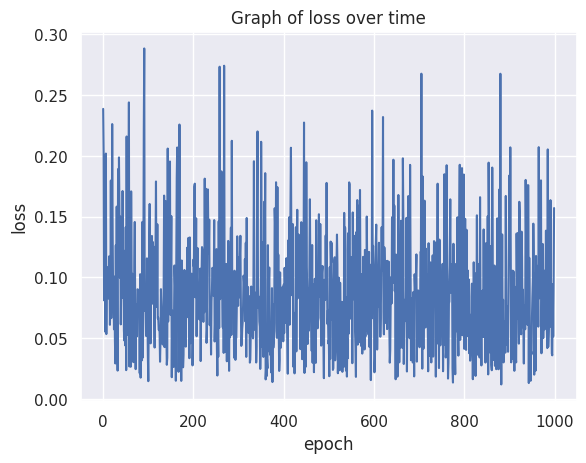

In [16]:
plt.plot(losses)
plt.title("Graph of loss over time")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Loss is then graphed and the elbow method is used for tuning of epochs for the greatest efficiency.

##**Testing the model**

*Tested using 10,000 test cases with a heat map for visualization*

In [13]:
### Don't bother unless you have a beefy GPU ###
#data_test_x = data_test_x.to("cuda")
#data_test_y = data_test_y.to("cuda")

prediction = model(data_test_x)
prediction_frame = pd.DataFrame(prediction.detach().numpy())
print(prediction_frame)
_, y_pred_tags = torch.max(prediction, dim = 1)
print(y_pred_tags)

              0         1          2
0      7.644931  0.000000  11.961569
1      4.982134  9.231733   0.000000
2     14.582010  0.000000   8.052835
3     14.212025  0.000000   8.028387
4     12.597684  0.000000   7.896870
...         ...       ...        ...
9995  13.683316  0.000000   8.019994
9996   9.002767  0.000000   0.908851
9997  13.186780  0.000000   8.025633
9998   4.842015  9.766386   0.000000
9999   5.784575  9.696033   0.000000

[10000 rows x 3 columns]
tensor([2, 1, 0,  ..., 0, 1, 1])


Once again the test uses softmax to predict the classes, and the final results are visualized as so:

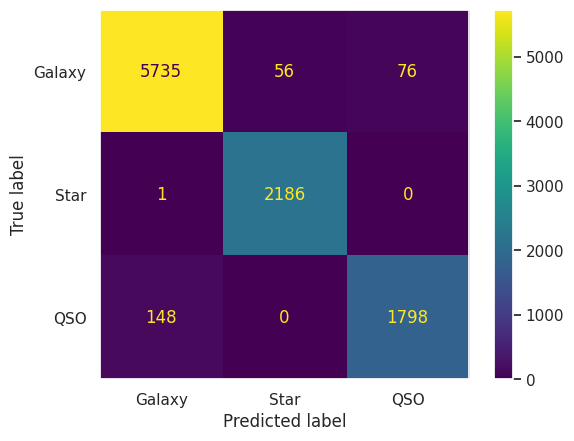

Testing Accuracy: 0.9719


In [15]:

cm = sklearn.metrics.confusion_matrix(data_test_y, y_pred_tags)

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.grid(False)
plt.show()

print("Testing Accuracy:", sklearn.metrics.accuracy_score(data_test_y, y_pred_tags))

The accuracy of the model tends to hover around 97% accuracy, which is within the boundaries I laid out as being a successful margin of error in my introduction. However, areas of future improvement would be best place in attempting to coax out differences between QSOs and Galaxies in my model, as this appears to be where the majority of false classifications can be found.